In [0]:
import torch
from torch.utils.data import DataLoader

import scipy.io
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Run once, then comment.
#"""
subprocess.call([
     "wget", "-P", "./data/",
     "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"])

subprocess.call([
     "wget", "-P", "./data/",
     "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"])
 
 #"""

def load_amat(path):
    mat = scipy.io.loadmat(path)
    x = mat['X']
    y = mat['y']
    x = np.moveaxis(x, 3, 0)
    x = np.moveaxis(x, 3, 1)
    x = x / 255
    return x.astype(np.float32), y

x_train, y_train = load_amat("data/train_32x32.mat")
x_test, _ = load_amat("data/test_32x32.mat")

print(x_train[0])

#x_train, x_val = train_test_split(x_train, test_size=0.1, stratify=y_train)
print(x_train.shape)

Batch_size = 128

#train_data=[]
#for i in range(x_train.shape[0]):
#  train_data.append((x_train[i],y_train[i]))

trainloader = DataLoader(x_train, batch_size=Batch_size , shuffle=True)
#validloader = DataLoader(x_val, batch_size=Batch_size , shuffle=False)
#testloader = DataLoader(x_test, batch_size=Batch_size , shuffle=False)

[[[0.12941177 0.05882353 0.05882353 ... 0.28235295 0.32156864 0.34901962]
  [0.10980392 0.05490196 0.05490196 ... 0.15686275 0.2627451  0.3254902 ]
  [0.15686275 0.07058824 0.0627451  ... 0.09019608 0.13725491 0.28235295]
  ...
  [0.3372549  0.34117648 0.32156864 ... 0.40784314 0.40784314 0.40392157]
  [0.32941177 0.3372549  0.32156864 ... 0.43137255 0.41568628 0.41568628]
  [0.33333334 0.34901962 0.33333334 ... 0.43529412 0.42745098 0.40392157]]

 [[0.11764706 0.09019608 0.06666667 ... 0.25490198 0.3019608  0.30980393]
  [0.15294118 0.09803922 0.07843138 ... 0.15294118 0.22745098 0.30588236]
  [0.16078432 0.08235294 0.06666667 ... 0.11372549 0.16470589 0.27058825]
  ...
  [0.31764707 0.32156864 0.30980393 ... 0.40784314 0.4117647  0.4117647 ]
  [0.3372549  0.30980393 0.29803923 ... 0.40392157 0.4117647  0.40784314]
  [0.34509805 0.32156864 0.30980393 ... 0.40784314 0.4117647  0.41568628]]

 [[0.14901961 0.07450981 0.07450981 ... 0.21960784 0.22352941 0.23137255]
  [0.13725491 0.086274

In [0]:
import os
import matplotlib.pyplot as plt
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np

class decoder(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(decoder, self).__init__()
        self.d = d
        
        self.deconv1 = nn.ConvTranspose2d(d, d*8, 4, 2, 1, bias=False)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1,bias=False)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1,bias=False)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1,bias=False)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1,bias=False)
        

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        # x = F.relu(self.deconv1(input))
        x = x.view(-1,self.d,1,1)
        x = F.leaky_relu(self.deconv1_bn(self.deconv1(x)), 0.2)
        x = F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x = torch.tanh(self.deconv5(x))

        return x
      
      
class generator(nn.Module):
    def __init__(self,d=128, decoder=decoder()):
      super(generator, self).__init__()
      self.decoder=decoder
    
    def forward(self, input):
      x=self.decoder(input)
      return x
    

class encoder(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1,bias=False)
        self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1,bias=False)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1,bias=False)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1,bias=False)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, d, 4, 2, 1,bias=False)
        


    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input,pretrain=0):
        # input = input.view(-1,28,28)
        # print (input.shape)
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = self.conv5(x)
        x = torch.sigmoid(x)
        
        return x
      
class discriminator(nn.Module):
    def __init__(self,d=128,encoder=encoder()):
      super(discriminator, self).__init__()
      self.d = d
      
      self.encoder=encoder
      self.linear = nn.Linear(d, 1)
      self.sigmoid = nn.Sigmoid()
    def forward(self, input):
      x = self.encoder(input)
      #print(x.shape)
      x = x.view(-1, self.d)
      x = self.linear(x)
      x = self.sigmoid(x)
      return x
  
  
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        #m.bias.data.zero_()



def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    z_ = torch.randn((2*2, NOISE_SIZE))
    z_ = Variable(z_.cuda())

    G.eval()
    test_images = G(fixed_z_) if isFix else G(z_)

    G.train()

    size_figure_grid = 2
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(8,8))
    for i in range(size_figure_grid):
      for j in range(size_figure_grid):
    
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(2*2):
        i = k // 2
        j = k % 2
        ax[i, j].cla()

        #print(type(test_images[k, :]))
        #print(test_images[k, :].shape)
        #print((test_images[k, :]))
        ax[i, j].imshow(test_images[k, :].cpu().data.permute(1,2,0).numpy())

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    print ("Saved to :",path)
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
        

def show_pretrain(x,num_epoch, show = False, save = False, path = 'result.png', isFix=False):
   

    en.eval()
    de.eval()
    x=torch.reshape(x,(1,3,32,32))
    x = Variable(x.cuda())
    test_images = de(en(x))
    x=x/2+0.5
    test_images=test_images/2+0.5

    en.train()
    de.train()


    size_figure_grid = [1,2]
    fig, ax = plt.subplots(size_figure_grid[0], size_figure_grid[1], figsize=(5, 5))

    ax[0].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)


    ax[0].cla()
    ax[1].cla()
    ax[0].imshow(x.cpu().detach().permute(0,2,3,1)[0].numpy())
    ax[1].imshow(test_images.cpu().detach().permute(0,2,3,1)[0].numpy())

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    print ("Saved to :",path)
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
        

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


def train_discriminator(x,mini_batch_size,pretrain=0):
    #if pretrain==1:
      
    #else:
    D.zero_grad()

    
    y_real = torch.ones(mini_batch_size)  # D(real) = 1
    y_fake = torch.zeros(mini_batch_size) # D(fake) = 0
    y_real, y_fake =  Variable(y_real.cuda()), Variable(y_fake.cuda())

    # Calculate loss for real sample
    # x = input.view(-1, 28, 28)
    x = Variable(x.cuda())
    #print(x.shape)

    D_real_result = D(x)
    #print(D_real_result.shape)
    D_real_loss = BCE_loss(D_real_result, y_real)

    # Calculate loss for generated sample
    z = torch.randn((mini_batch_size, NOISE_SIZE))
    z = Variable(z.cuda())
    G_result = G(z) # Generator's result
    
    #print(mini_batch_size)

    gradz=Gradz(D,x,G_result)

    #print(gradz)



    loss=WD_loss(x,G_result,gradz)

    D_fake_result = D(G_result.detach()) # detach?
    D_fake_loss = BCE_loss(D_fake_result, y_fake)

    # Calculating total loss
    D_train_loss = D_real_loss + D_fake_loss

    # Propogate loss backwards and return loss
    D_train_loss.backward()
    D_optimizer.step()
    return D_train_loss.item()
    

def train_generator(mini_batch_size):
    G.zero_grad()

    # Generate z with random values
    z = torch.randn((mini_batch_size, NOISE_SIZE)).cuda()
    y = torch.ones(mini_batch_size)     # Attempting to be real
    z, y = Variable(z.cuda()), Variable(y.cuda())

    # Calculate loss for generator
    # Comparing discriminator's prediction with ones (ie, real)
    G_result = G(z)
    D_result = D(G_result)
    #D_result 
    G_train_loss = BCE_loss(D_result, y)

    # Propogate loss backwards and return loss
    G_train_loss.backward()
    G_optimizer.step()
    return G_train_loss.item()
  
def train_pretrain(x,mini_batch_size):
    en.zero_grad()
    de.zero_grad()
    x = Variable(x.cuda())

    AE_result = de(en(x))
    #print(AE_result.shape,x.shape)
    loss = AE_loss(x,AE_result)
    loss.backward()
    AE_en_optimizer.step()
    AE_de_optimizer.step()
    #AE_optimizer.step()

    # Generate z with random values
    
    
    return loss.item()

def save_models(train_hist):
    torch.save(G.state_dict(), PATH+"/generator_param_"+str(train_epoch)+".pkl")
    torch.save(D.state_dict(), PATH +"/discriminator_param_"+str(train_epoch)+".pkl")

    with open(PATH+'/train_hist.pkl', 'wb') as f:
        pickle.dump(train_hist, f)

def save_gif():
    images = []
    for e in range(train_epoch):
        img_name = PATH+'/Fixed_results/MNIST_DCGAN_' + str(e + 1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(PATH+'/generation_animation.gif', images, fps=5)

def train():
    train_hist = {'D_losses':[],'G_losses':[]}

    
    for epoch in range(train_epoch):
        D_losses = []
        G_losses = []
        iter_lim = 0
        for x_ in trainloader:
            #print(x_)
            #print(torch.mean(x_),torch.std(x_))
            #break
            iter_lim+=1
            #if iter_lim == 100:
             #   break
            mini_batch_size = x_.size()[0]
            #print("minibatch",mini_batch_size)
            D_loss = train_discriminator(x_,mini_batch_size)
            D_losses.append(D_loss)
            #D_loss = train_discriminator(x_,mini_batch_size)
            #D_losses.append(D_loss)

            G_loss = train_generator(mini_batch_size)
            G_losses.append(G_loss)

        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch + 1), train_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
        p = PATH+'/Random_results/Street_view_' + str(epoch + 1) + '.png'
        p_fixed = PATH+'/Fixed_results/Street_view_' + str(epoch + 1) + '.png'
        show_result((epoch+1), save=True, path=p, isFix=False)
        show_result((epoch+1), save=True, path=p_fixed, isFix=True)

        train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
        train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))

def pretrain():
    for epoch in range(train_ae_epoch):
        losses = []
        for x_ in trainloader:

            mini_batch_size = x_.size()[0]
            loss = train_pretrain(x_,mini_batch_size)
            losses.append(loss)
            x=x_[-1]
 

        print('[%d/%d]: loss: %.3f' % (
            (epoch + 1), train_epoch, torch.mean(torch.FloatTensor(losses))))
        p = PATH+'/pretrain/Street_view_pretrain_' + str(epoch + 1) + '.png'
        show_pretrain(x,(epoch+1), save=True, path=p)

        
          





In [0]:
def Gradz(model, p, q):
  
  #optimizer.zero_grad()
  
  #x = torch.FloatTensor(next(p)).to(device)
  #y = torch.FloatTensor(next(q)).to(device)
  #a=torch.randn((512,2)).to(device)
  #a.expand(x.shape)
  b_s=p.shape[0]
  alpha = torch.randn(b_s, 1)
  #print(alpha.shape,p.size(),p.shape)
  alpha = alpha.repeat((1,3*32*32))
  alpha=alpha.view(b_s,3,32,32)
  alpha = alpha.cuda()
  #print(alpha.shape,p.shape,q.shape)
  z = alpha*(p) + (1 - alpha)*q

  #z=a*x+(1-a)*y
  z=Variable(z.data, requires_grad=True)
  z.retain_grad()

  out=model(z)
  torch.sum(out).backward()
  
  norm=(torch.sqrt(torch.sum(z.grad**2, dim=1))-1)**2
  D_optimizer.zero_grad()
  G_optimizer.zero_grad()
  return norm



def WD_loss(x,y,grad):
  
  l=10
  obj= torch.mean(x) - torch.mean(y)- l * torch.mean(grad)
  
  #loss=-l*norm
  return -obj


# training parameters
batch_size = Batch_size
lr = 0.0002
lr_D=0.0002
train_epoch = 20
train_ae_epoch = 5

PATH = './Street_view_results'
NOISE_SIZE = 128

fixed_z_ = torch.randn((5 * 5, NOISE_SIZE))    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda())

# data_loader

#trainloader = DataLoader(x_train, batch_size=Batch_size , shuffle=True)
#validloader = DataLoader(x_val, batch_size=Batch_size , shuffle=False)
#testloader = DataLoader(x_test, batch_size=Batch_size , shuffle=False)

# network



pretrain_true=0

d=100
 
de = decoder(d)
en = encoder(d)
de.weight_init(mean=0.0, std=0.02)
en.weight_init(mean=0.0, std=0.02)

en.cuda()
de.cuda()

if pretrain_true==1:
  en.load_state_dict(torch.load("en.pt"))
  de.load_state_dict(torch.load("de.pt"))




print ("Created models")
# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()
AE_loss=nn.MSELoss()
# Adam optimizer
AE_en_optimizer = optim.Adam(en.parameters(), lr=lr, betas=(0.5, 0.999))
AE_de_optimizer = optim.Adam(de.parameters(), lr=lr, betas=(0.5, 0.999))
 
# results save folder
if not os.path.isdir(PATH):
    os.mkdir(PATH)
if not os.path.isdir(PATH+'/Random_results'):
    os.mkdir(PATH+'/Random_results')
if not os.path.isdir(PATH+'/Fixed_results'):
    os.mkdir(PATH+'/Fixed_results')
if not os.path.isdir(PATH+'/pretrain'):
    os.mkdir(PATH+'/pretrain')
    
    
    
pretrain()    
    
G = generator(d,de)
D = discriminator(d,en)
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5, 0.999))

model_parameters = filter(lambda p: p.requires_grad, G.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
model_parameters = filter(lambda p: p.requires_grad, D.parameters())
params += sum([np.prod(p.size()) for p in model_parameters])
print(params)

G.cuda()
D.cuda()

if pretrain_true==1:
  G.load_state_dict(torch.load("G.pt"))
  D.load_state_dict(torch.load("D.pt"))

train()


Created models
[1/20]: loss: 0.017
Saved to : ./Street_view_results/pretrain/Street_view_pretrain_1.png
[2/20]: loss: 0.003
Saved to : ./Street_view_results/pretrain/Street_view_pretrain_2.png
[3/20]: loss: 0.003
Saved to : ./Street_view_results/pretrain/Street_view_pretrain_3.png
[4/20]: loss: 0.002
Saved to : ./Street_view_results/pretrain/Street_view_pretrain_4.png
[5/20]: loss: 0.002
Saved to : ./Street_view_results/pretrain/Street_view_pretrain_5.png
7612289


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([41])) that is different to the input size (torch.Size([41, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/20]: loss_d: 1.134, loss_g: 1.562
Saved to : ./Street_view_results/Random_results/Street_view_1.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved to : ./Street_view_results/Fixed_results/Street_view_1.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/20]: loss_d: 0.967, loss_g: 1.968
Saved to : ./Street_view_results/Random_results/Street_view_2.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved to : ./Street_view_results/Fixed_results/Street_view_2.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/20]: loss_d: 0.862, loss_g: 2.158
Saved to : ./Street_view_results/Random_results/Street_view_3.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved to : ./Street_view_results/Fixed_results/Street_view_3.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/20]: loss_d: 0.674, loss_g: 2.549
Saved to : ./Street_view_results/Random_results/Street_view_4.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved to : ./Street_view_results/Fixed_results/Street_view_4.png
[5/20]: loss_d: 0.474, loss_g: 3.031


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved to : ./Street_view_results/Random_results/Street_view_5.png
Saved to : ./Street_view_results/Fixed_results/Street_view_5.png
[6/20]: loss_d: 0.387, loss_g: 3.554
Saved to : ./Street_view_results/Random_results/Street_view_6.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved to : ./Street_view_results/Fixed_results/Street_view_6.png
[7/20]: loss_d: 0.384, loss_g: 3.618
Saved to : ./Street_view_results/Random_results/Street_view_7.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved to : ./Street_view_results/Fixed_results/Street_view_7.png
[8/20]: loss_d: 0.395, loss_g: 3.473
Saved to : ./Street_view_results/Random_results/Street_view_8.png
Saved to : ./Street_view_results/Fixed_results/Street_view_8.png
[9/20]: loss_d: 0.406, loss_g: 3.513
Saved to : ./Street_view_results/Random_results/Street_view_9.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved to : ./Street_view_results/Fixed_results/Street_view_9.png
[10/20]: loss_d: 0.356, loss_g: 3.498
Saved to : ./Street_view_results/Random_results/Street_view_10.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved to : ./Street_view_results/Fixed_results/Street_view_10.png
[11/20]: loss_d: 0.378, loss_g: 3.463
Saved to : ./Street_view_results/Random_results/Street_view_11.png
Saved to : ./Street_view_results/Fixed_results/Street_view_11.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12/20]: loss_d: 0.358, loss_g: 3.590
Saved to : ./Street_view_results/Random_results/Street_view_12.png
Saved to : ./Street_view_results/Fixed_results/Street_view_12.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13/20]: loss_d: 0.321, loss_g: 3.477
Saved to : ./Street_view_results/Random_results/Street_view_13.png
Saved to : ./Street_view_results/Fixed_results/Street_view_13.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[14/20]: loss_d: 0.335, loss_g: 3.591
Saved to : ./Street_view_results/Random_results/Street_view_14.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved to : ./Street_view_results/Fixed_results/Street_view_14.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15/20]: loss_d: 0.342, loss_g: 3.640
Saved to : ./Street_view_results/Random_results/Street_view_15.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved to : ./Street_view_results/Fixed_results/Street_view_15.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[16/20]: loss_d: 0.344, loss_g: 3.561
Saved to : ./Street_view_results/Random_results/Street_view_16.png
Saved to : ./Street_view_results/Fixed_results/Street_view_16.png
[17/20]: loss_d: 0.285, loss_g: 3.657
Saved to : ./Street_view_results/Random_results/Street_view_17.png
Saved to : ./Street_view_results/Fixed_results/Street_view_17.png
[18/20]: loss_d: 0.330, loss_g: 3.735
Saved to : ./Street_view_results/Random_results/Street_view_18.png
Saved to : ./Street_view_results/Fixed_results/Street_view_18.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19/20]: loss_d: 0.288, loss_g: 3.751
Saved to : ./Street_view_results/Random_results/Street_view_19.png
Saved to : ./Street_view_results/Fixed_results/Street_view_19.png
[20/20]: loss_d: 0.316, loss_g: 3.801
Saved to : ./Street_view_results/Random_results/Street_view_20.png
Saved to : ./Street_view_results/Fixed_results/Street_view_20.png


In [0]:


torch.save(G.state_dict(), "G.pt")
torch.save(D.state_dict(), "D.pt")
torch.save(en.state_dict(), "en.pt")
torch.save(de.state_dict(), "de.pt")

In [0]:
!zip -r /content/file.zip /content/
#from google.colab import files
#files.download("/content/file.zip")

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 21%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2019.04.04/ (stored 0%)
  adding: content/.config/logs/2019.04.04/20.19.44.739582.log (deflated 86%)
  adding: content/.config/logs/2019.04.04/20.19.36.190610.log (deflated 54%)
  adding: content/.config/logs/2019.04.04/20.19.48.237315.log (deflated 54%)
  adding: content/.config/logs/2019.04.04/20.19.32.062115.log (deflated 91%)
  adding: content/.config/logs/2019.04.04/20.19.47.466075.log (deflated 55%)
  adding: content/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/ (stored 0%)
  adding: content/data/te

In [0]:
d=100
 
de = decoder(d)
en = encoder(d)
G = generator(d,de)
D = discriminator(d,en)


G.load_state_dict(torch.load("../content/G.pt"))
D.load_state_dict(torch.load("../content/D.pt"))
en.load_state_dict(torch.load("../content/en.pt"))
de.load_state_dict(torch.load("../content/de.pt"))

torch.Size([128])
torch.Size([1, 3, 32, 32])


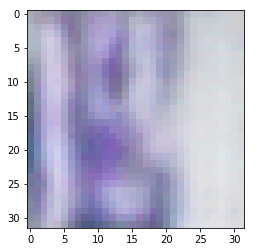

In [0]:
G.cuda()
with torch.no_grad():
  G.eval()
  zz = torch.normal(torch.zeros(100),1).cuda()
  print(zz.shape)
  test_img = G(zz)
  print(test_img.shape)
  test_img = test_img.view(3,32,32)
  plt.imshow(test_img.cpu().permute(1,2,0))
  G.train()

## Generating examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


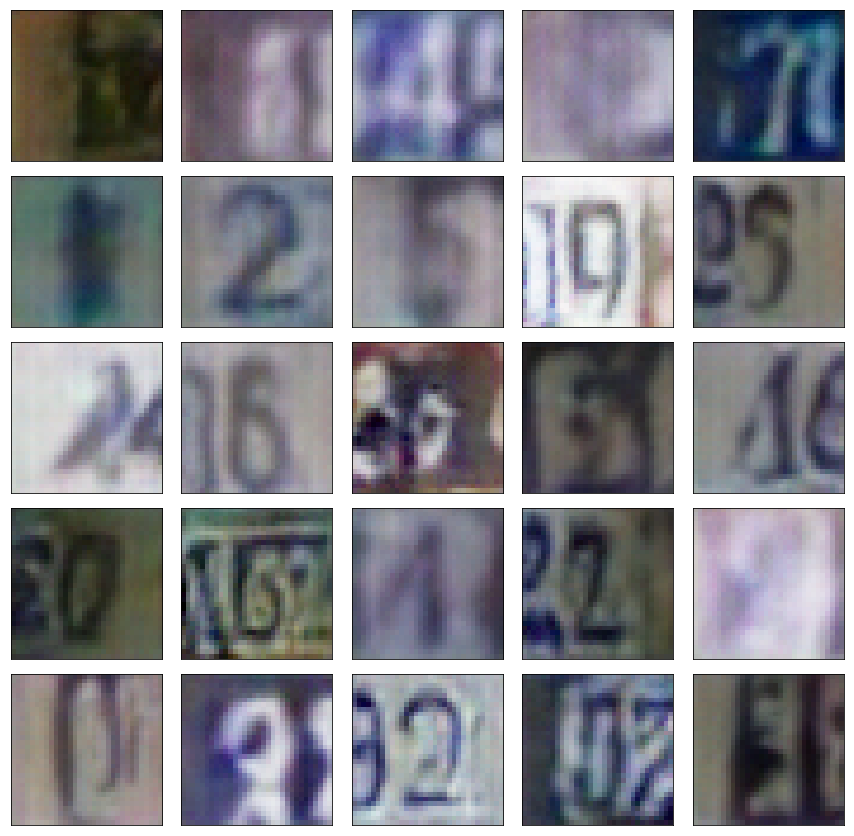

In [0]:
with torch.no_grad():
  fig,axis = plt.subplots(5,5,figsize=(15,15))
  for i in range(25):
    example = torch.normal(torch.zeros(100),1).cuda()
    img = G(example)
    img = img.view(3,32,32)
    img = img.cpu().permute(1,2,0)

    axis[i//5, i%5].imshow(img)
    axis[i//5, i%5].get_xaxis().set_ticks([])
    axis[i//5, i%5].get_yaxis().set_ticks([])
    axis[i//5, i%5].set_aspect('equal')

  fig.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show() 

## Disentangled Representation

torch.Size([128])
torch.Size([1, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

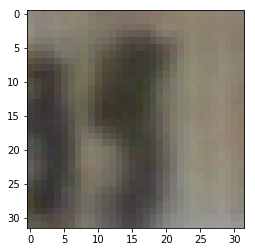

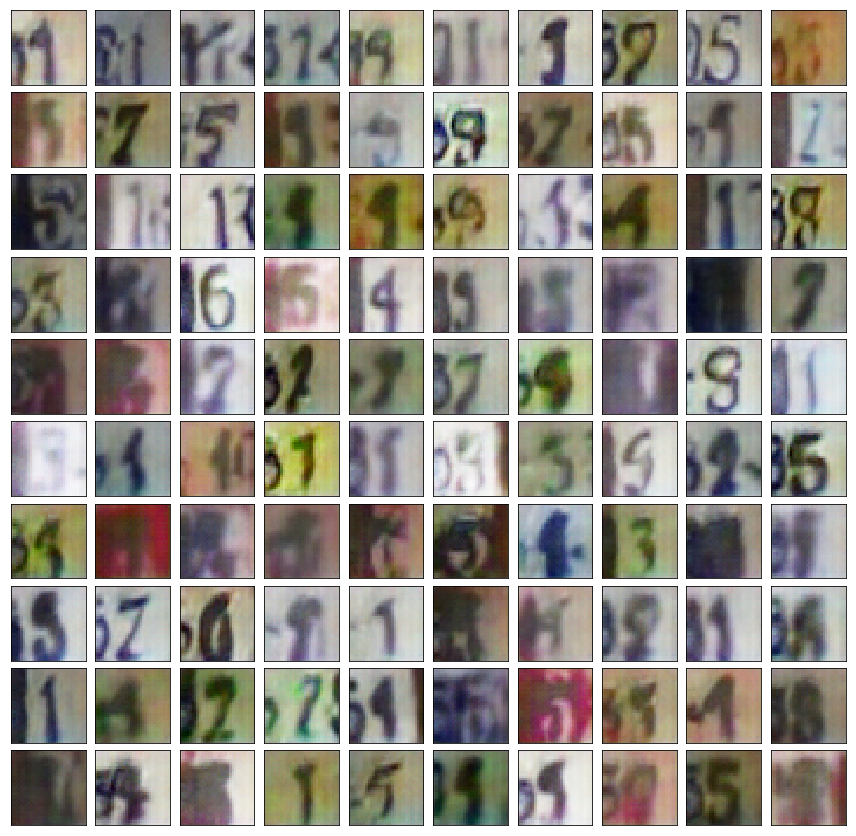

In [0]:
##### Disentangled Representation

with torch.no_grad():
  zz = torch.normal(torch.zeros(100),1).cuda()
  print(zz.shape)
  test_img = G(zz)
  print(test_img.shape)
  test_img = test_img.view(3,32,32)
  plt.imshow(test_img.cpu().permute(1,2,0))

  ## Let's explore the dimensions
  variation = 10

  fig, axis = plt.subplots(10,10,figsize=(15,15))
  for i in range(100):
    perturbed = zz.clone().detach()
    perturbed[i] = perturbed[i] + variation

    slide_img = G(perturbed)
    slide_img = slide_img.view(3,32,32)
    slide_img = slide_img.cpu().permute(1,2,0)

    axis[i//10, i%10].imshow(slide_img)
    axis[i//10, i%10].get_xaxis().set_ticks([])
    axis[i//10, i%10].get_yaxis().set_ticks([])
    axis[i//10, i%10].set_aspect('equal')

  fig.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()  

## Interpolating data space\latent space

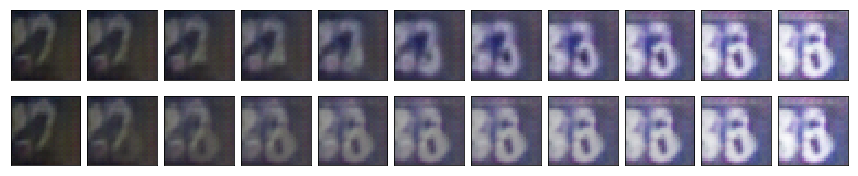

In [0]:
with torch.no_grad():
  z0 = torch.normal(torch.zeros(100),1).cuda()
  z1 = torch.normal(torch.zeros(100),1).cuda()

  g0 = G(z0)
  g0 = g0.view(3,32,32)
  g0 = g0.cpu().permute(1,2,0)

  g1 = G(z1)
  g1 = g1.view(3,32,32)
  g1 = g1.cpu().permute(1,2,0)

  alpha = np.linspace(0,1,11)

  ##Walking in z space

  fig1, axis = plt.subplots(2,11,figsize=(15,3))

  for i in range(11):
    walk = alpha[i]*z0 + (1-alpha[i])*z1
    walk_img = G(walk)
    walk_img = walk_img.view(3,32,32)
    walk_img = walk_img.cpu().permute(1,2,0)

    axis[0,i].imshow(walk_img)
    axis[0,i].get_xaxis().set_ticks([])
    axis[0,i].get_yaxis().set_ticks([])
    axis[0,i].set_aspect('equal')

    walk_img2 = alpha[i]*g0 + (1-alpha[i])*g1

    axis[1,i].imshow(walk_img2)
    axis[1,i].get_xaxis().set_ticks([])
    axis[1,i].get_yaxis().set_ticks([])
    axis[1,i].set_aspect('equal')

  fig1.subplots_adjust(wspace=0.1, hspace=0.1)
  fig1.show()    


## Generating 1000 images

In [0]:
from PIL import Image
import matplotlib
import torchvision

base_path = "../content/sample_data/GAN_example"
with torch.no_grad():
  for i in range(1000):
    G.eval()
    zz = torch.normal(torch.zeros(100),1).cuda()
    img = G(zz)
    img = (img.view(3,32,32)*2)-1
    #img = img.cpu().permute(1,2,0)
    torchvision.utils.save_image(img,base_path+str(i+1)+".jpeg",normalize=True)
    

In [0]:
!zip -r /content/scrap.zip /content/sample_data

  adding: content/sample_data/ (stored 0%)
  adding: content/sample_data/GAN_example637.jpeg (deflated 20%)
  adding: content/sample_data/GAN_example900.jpeg (deflated 19%)
  adding: content/sample_data/GAN_example312.jpeg (deflated 19%)
  adding: content/sample_data/GAN_example303.jpeg (deflated 20%)
  adding: content/sample_data/GAN_example589.jpeg (deflated 20%)
  adding: content/sample_data/GAN_example950.jpeg (deflated 19%)
  adding: content/sample_data/GAN_example608.jpeg (deflated 20%)
  adding: content/sample_data/GAN_example534.jpeg (deflated 19%)
  adding: content/sample_data/GAN_example814.jpeg (deflated 18%)
  adding: content/sample_data/GAN_example242.jpeg (deflated 19%)
  adding: content/sample_data/GAN_example144.jpeg (deflated 19%)
  adding: content/sample_data/GAN_example118.jpeg (deflated 20%)
  adding: content/sample_data/GAN_example8.jpeg (deflated 20%)
  adding: content/sample_data/GAN_example929.jpeg (deflated 19%)
  adding: content/sample_data/GAN_example844.jpeg